For this project, my idea is to predict housing price from appartments' announces in Paris. The goal is to get a model at least better than a simple multiplication between the area and the square meter price by district. To answer this question, I scraped data from Leboncoin.

The report is made of different parts describing the different steps I followed to adress my question.

In [3]:
# Display the menus
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
# Import modules
import os
import pandas as pd
import numpy as np
import urllib
from urllib import request
import bs4
from slimit import ast
from slimit.parser import Parser
from slimit.visitors import nodevisitor
import math
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
from pandas.plotting import scatter_matrix
from string import digits
from nltk.corpus import stopwords
import string
from nltk.stem.snowball import FrenchStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
import pickle

pd.options.display.max_columns = 100
os.chdir('/Users/Linger/Desktop/ENSAE_MS/S1/Python/Projet')

## 1] Scrapping

### a) Get announces' URLs

The aim of this step is to crawl all the webpages (of www.leboncoin.fr) corresponding to the search 'Appartement' and 'Paris', in order to get all the coresponding announces urls.

In [31]:
list_url = []
list_title = []
list_image = []

number_webpages_crawled = 80

for i in range(number_webpages_crawled):
    # Loop over all the webpages from which want to extract information
    url_appartment = "https://www.leboncoin.fr/ventes_immobilieres/offres/ile_de_france/?o={}&q=appartement&location=Paris".format(i+1)  
    # Read html of webpage
    request_text = request.urlopen(url_appartment).read()
    page = bs4.BeautifulSoup(request_text, "lxml")
    # Get a dataframe with the name of the announces, their URL, and if they have photo
    for item in page.find('section', {'class' : 'tabsContent block-white dontSwitch'}).findAll({'a'}):
        list_url.append(item.get("href"))
        list_title.append(item.get("title"))
        if item.find("span", {"class":"lazyload"}):
            list_image.append(1)
        else:
            list_image.append(0)

In [445]:
# Create the corresponding dataframe
df = pd.DataFrame.from_dict({"announce" : list_title, 'url' : list_url, "image" : list_image})
print("Number of webpages crawled --> {}".format(number_webpages_crawled))
print("Number of announces crawled --> {}".format(df.shape[0]))

Number of webpages crawled --> 80
Number of announces crawled --> 2787


The final dataset I will get will be made of 2,787 observation.

### b) Data scrapping

With this code, I go on each announces' url, and I scrap information regarding appartments' features, as well as announces' description.

In [33]:
final_data = {} 
description = []

for i, url in enumerate(df.url):
    # Loop over all the ur of the previously created data
    request_text = request.urlopen('http:{}'.format(url)).read()
    subpage = bs4.BeautifulSoup(request_text, "lxml")
    # Get the tag to parse
    info_to_parse = subpage.find('body', {'class' : 'ua_UNK'}).findAll('script')[3].text
    # Use a parser to create a dict with all the information I can extract from the tag
    parser = Parser()
    tree = parser.parse(info_to_parse)
    fields = {getattr(node.left, 'value', ''): getattr(node.right, 'value', '')
              for node in nodevisitor.visit(tree)
              if isinstance(node, ast.Assign)}
    # Do a loop to add to the data the inforation from the URL: (i) If the information is available, add it ; (ii) if
    # the information is new, create anex variable (and adding NaN for all the previously crawled urls) ; (iii) add a
    # NaN value for the information not available in the url crawled.
    treated_keys = []
    for keys, values in fields.items():
        if keys not in final_data:
            new_variable = list(np.repeat(np.nan,i))
            new_variable.append(values)
            final_data[keys] = new_variable
        else:
            final_data[keys].append(values)
        treated_keys.append(keys)
    for keys in [i for i in final_data if i not in treated_keys]:
        final_data[keys].append(np.nan)
    # Get the text description
    if subpage.find('p', {'class':"value", 'itemprop':"description"}):
        description.append(subpage.find('p', {'class':"value", 'itemprop':"description"}).text)
    else:
        description.append(np.nan)
    print(i/len(df.url))

0.0


0.006172839506172839


0.012345679012345678


0.018518518518518517


0.024691358024691357


0.030864197530864196


0.037037037037037035


0.043209876543209874


0.04938271604938271


0.05555555555555555


0.06172839506172839


0.06790123456790123


0.07407407407407407


0.08024691358024691


0.08641975308641975


0.09259259259259259


0.09876543209876543


0.10493827160493827


0.1111111111111111


0.11728395061728394


0.12345679012345678


0.12962962962962962


0.13580246913580246


0.1419753086419753


0.14814814814814814


0.15432098765432098


0.16049382716049382


0.16666666666666666


0.1728395061728395


0.17901234567901234


0.18518518518518517


0.19135802469135801


0.19753086419753085


0.2037037037037037


0.20987654320987653


0.21604938271604937


0.2222222222222222


0.22839506172839505


0.2345679012345679


0.24074074074074073


0.24691358024691357


0.25308641975308643


0.25925925925925924


0.2654320987654321


0.2716049382716049


0.2777777777777778


0.2839506172839506


0.29012345679012347


0.2962962962962963


0.30246913580246915


0.30864197530864196


0.3148148148148148


0.32098765432098764


0.3271604938271605


0.3333333333333333


0.3395061728395062


0.345679012345679


0.35185185185185186


0.35802469135802467


0.36419753086419754


0.37037037037037035


0.3765432098765432


0.38271604938271603


0.3888888888888889


0.3950617283950617


0.4012345679012346


0.4074074074074074


0.41358024691358025


0.41975308641975306


0.42592592592592593


0.43209876543209874


0.4382716049382716


0.4444444444444444


0.4506172839506173


0.4567901234567901


0.46296296296296297


0.4691358024691358


0.47530864197530864


0.48148148148148145


0.4876543209876543


0.49382716049382713


0.5


0.5061728395061729


0.5123456790123457


0.5185185185185185


0.5246913580246914


0.5308641975308642


0.5370370370370371


0.5432098765432098


0.5493827160493827


0.5555555555555556


0.5617283950617284


0.5679012345679012


0.5740740740740741


0.5802469135802469


0.5864197530864198


0.5925925925925926


0.5987654320987654


0.6049382716049383


0.6111111111111112


0.6172839506172839


0.6234567901234568


0.6296296296296297


0.6358024691358025


0.6419753086419753


0.6481481481481481


0.654320987654321


0.6604938271604939


0.6666666666666666


0.6728395061728395


0.6790123456790124


0.6851851851851852


0.691358024691358


0.6975308641975309


0.7037037037037037


0.7098765432098766


0.7160493827160493


0.7222222222222222


0.7283950617283951


0.7345679012345679


0.7407407407407407


0.7469135802469136


0.7530864197530864


0.7592592592592593


0.7654320987654321


0.7716049382716049


0.7777777777777778


0.7839506172839507


0.7901234567901234


0.7962962962962963


0.8024691358024691


0.808641975308642


0.8148148148148148


0.8209876543209876


0.8271604938271605


0.8333333333333334


0.8395061728395061


0.845679012345679


0.8518518518518519


0.8580246913580247


0.8641975308641975


0.8703703703703703


0.8765432098765432


0.8827160493827161


0.8888888888888888


0.8950617283950617


0.9012345679012346


0.9074074074074074


0.9135802469135802


0.9197530864197531


0.9259259259259259


0.9320987654320988


0.9382716049382716


0.9444444444444444


0.9506172839506173


0.9567901234567902


0.9629629629629629


0.9691358024691358


0.9753086419753086


0.9814814814814815


0.9876543209876543


0.9938271604938271


In [34]:
# Create data
final_data['description'] = description
df_2 = pd.DataFrame.from_dict(final_data)

data = pd.concat([df, df_2], axis = 1)

Here is the head of the data I got. I have numerical, categorical and textual features.

In [441]:
data.head()

,announce,image,url,ad_type,booster,boutique_id,boutique_name,cat,cat_id,city,compte,cp,daily_bump,daily_bump30,departement,description,device,displaytype,environnement,eventname,gallery,gallery30,ges,last_update_date,ldv,listid,nbphoto,nrj,oas_cat,oas_departement,oas_region,oas_subcat,offres,options,pagename,pagetype,photosup,pieces,piecesmax,piecesmin,prix,prixmax,prixmin,publish_date,region,siren,store_id_annonceur,sub_toplist,subcat,subcat_id,surface,surfacemax,surfacemin,titre,type,uab,urgent
0,Appartement 2 pièces 66 m²,1,//www.leboncoin.fr/ventes_immobilieres/1304297...,"""offres""","""0""","""51182""","""activ_immobilier""","""immobilier""","""8""","""paris""","""0""","""75003""","""0""","""0""","""paris""",Grand F2 Coeur du Haut MaraisDans le coeur du ...,NaN,NaN,"""prod""","""ad_view::detail""","""0""","""0""",NaN,"""15/09/2017""","""0""","""1304297520""","""8""",NaN,"""immobilier""","""75""","""12""","""ventes_immobilieres""","""pro""",NaN,"""adview""","""annonce""","""0""","""2""","""3""","""1""","""925000""","""1000000""","""900000""","""15/09/2017""","""ile_de_france""","""508161650""","""16745411""","""0""","""ventes_immobilieres""","""9""","""66""","""70""","""60""","""appartement_2_pieces_66_m2""","""appartement""",NaN,"""0"""
1,Appartement 2 pièces 44 m²,1,//www.leboncoin.fr/ventes_immobilieres/1304311...,"""offres""","""0""",NaN,NaN,"""immobilier""","""8""","""paris""","""0""","""75012""","""0""","""0""","""paris""",PICPUSPICPUS. Dans un immeuble de bon standing...,NaN,NaN,"""prod""","""ad_view::detail""","""0""","""0""",NaN,"""15/09/2017""","""0""","""1304311061""","""3""",NaN,"""immobilier""","""75""","""12""","""ventes_immobilieres""","""pro""",NaN,"""adview""","""annonce""","""0""","""2""","""3""","""1""","""415000""","""450000""","""400000""","""15/09/2017""","""ile_de_france""","""451294003""","""7866322""","""0""","""ventes_immobilieres""","""9""","""44""","""50""","""40""","""appartement_2_pieces_44_m2""","""appartement""",NaN,"""0"""
2,Appartement 4 pièces 85 m²,1,//www.leboncoin.fr/ventes_immobilieres/1304066...,"""offres""","""0""","""44303""","""l_adresse_societe_novae""","""immobilier""","""8""","""paris""","""0""","""75013""","""0""","""0""","""paris""",4 pièce(s) 85 m2 avec balcon et parkingsL'Adre...,NaN,NaN,"""prod""","""ad_view::detail""","""0""","""0""",NaN,"""15/09/2017""","""0""","""1304066389""","""8""",NaN,"""immobilier""","""75""","""12""","""ventes_immobilieres""","""pro""",NaN,"""adview""","""annonce""","""0""","""4""","""5""","""3""","""675900""","""700000""","""650000""","""15/09/2017""","""ile_de_france""","""514751999""","""253123""","""0""","""ventes_immobilieres""","""9""","""85""","""90""","""80""","""appartement_4_pieces_85_m2""","""appartement""",NaN,"""0"""
3,Appartement 2 pièces 46 m²,1,//www.leboncoin.fr/ventes_immobilieres/1146204...,"""offres""","""0""","""49680""","""my_home_connexion_immobilier""","""immobilier""","""8""","""paris""","""0""","""75016""","""0""","""0""","""paris""",PARIS XVI - RUE CLAUDE TERRASSE - 2 PIECES BIE...,NaN,NaN,"""prod""","""ad_view::detail""","""0""","""0""",NaN,"""15/09/2017""","""0""","""1146204558""","""7""","""v""","""immobilier""","""75""","""12""","""ventes_immobilieres""","""pro""",NaN,"""adview""","""annonce""","""0""","""2""","""3""","""1""","""395000""","""400000""","""350000""","""07/06/2017""","""ile_de_france""","""799853270""","""12265619""","""0""","""ventes_immobilieres""","""9""","""46""","""50""","""40""","""appartement_2_pieces_46_m2""","""appartement""",NaN,"""0"""
4,Appartement 2 pièces 54 m²,1,//www.leboncoin.fr/ventes_immobilieres/1303994...,"""offres""","""0""",NaN,NaN,"""immobilier""","""8""","""paris""","""0""","""75015""","""0""","""0""","""paris""",2 PIECES DE 54M² + BALCON 4M²SAINT CHARLES LIM...,NaN,NaN,"""prod""","""ad_view::detail""","""0""","""0""","""f""","""15/09/2017""","""0""","""1303994672""","""6""","""f""","""immobilier""","""75""","""12""","""ventes_immobilieres""","""pro""",NaN,"""adview""","""anno

In [37]:
data.to_csv('/Users/Linger/Desktop/ENSAE_MS/S1/Python/Projet/data_16')

## 2] Data cleaning

### a) Concatenate data

Since the scrapping step was challenging for my computer, I scrapped webpages 5 by 5. The aim of this first part is to concatenate observations in a unique dataframe.

In [538]:
data = pd.DataFrame()
number_of_dataset = 16

for i in range(number_of_dataset):
    df = pd.read_csv('data_{}'.format(i+1), index_col=0)
    if len(data)==0:
        data = df
    else:
        data = pd.concat([data,df])

# Rename row indexes
data.index = range(len(data))
data.shape

(2787, 57)

The concatenated data is made of 2,787 observations and 57 variables.

### b) Delete variables not bringing information

When scrapping, I got numerous variables with only one category, or with too many NaN. Therefore, I will not use these variables and stay focus only on usefull variables. I end up with 11 variables.

In [539]:
# Which variables are only NaN?
empty_variables = list(data.columns[data.isnull().sum() == len(data)])
data = data.drop(empty_variables, axis=1)
# Which variables has only one value?
variables_without_info = list(data.columns[data.nunique() == 1])
data = data.drop(variables_without_info, axis=1)
# Drop variable based on their meaning or redundancy
data = data.drop(['url', 'daily_bump', 'daily_bump30', 'gallery', 'gallery30', 'last_update_date', 'listid',
                 'piecesmax', 'piecesmin', 'prixmax', 'prixmin', 'publish_date', 'siren', 'store_id_annonceur',
                 'sub_toplist', 'surfacemax', 'surfacemin', 'image', 'urgent'], axis=1)
# Drop variables boutique_id, boutique_name because they have too much NaN
data = data.drop(['boutique_id', 'boutique_name'], axis=1)

data.shape

(2787, 12)

### c) Change type of variables

Here I change the type of some variables. Indeed, when scrapping the data, I end up with string variables, which are in fact numeric.

In [540]:
# Delete the ""
data = data.replace({'"':''}, regex=True)

# Convert numerical variables to float64
numerical_var_wanted = ['nbphoto', 'pieces', 'prix', 'surface']
data[numerical_var_wanted] = data[numerical_var_wanted].astype('float64')

### d) Data interpolation (announces' description parsing)

In [541]:
# How many NaN each variable does contain?
pd.DataFrame(data.isnull().sum()).transpose()

,announce,cp,description,ges,nbphoto,nrj,offres,pieces,prix,surface,titre,type
0,0,0,0,1087,0,912,0,37,8,28,0,30


Variables related to the number of rooms and are sometimes missing. Since they are important for the prediction, we try to recover them from the announces' description.

Then, even if ges and nrj have a lot of NaN, we keep them because I think they are important for housing price prediction.

We will not try to recover information related to price, because there are only 8 observations with missing price. Therefore, we will drop these observations from the data.

#### Retrive missing number of rooms

For some observations, it is possible to retrive the number of rooms by parsing announce's titles and description.

In [542]:
for i in range(len(data)):
    if math.isnan(data.pieces[i]):
        if 'pieces' in data.titre[i].split('_'):
            try:
                data.loc[i, 'pieces'] = int(data.titre[i].split('_')[[max(0,k-1) for k, j in enumerate(data.titre[i].split('_')) if j == 'pieces'][0]])
            except ValueError:
                data.loc[i, 'pieces'] = np.nan
        elif 'pieces' in data.description[i].lower().split(' '):
            try:
                data.loc[i, 'pieces'] = int(data.description[i].split(' ')[[max(0,k-1) for k, j in enumerate(data.description[i].split(' ')) if j == 'pieces'][0]])
            except ValueError:
                data.loc[i, 'pieces'] = np.nan
        else:
            data.loc[i, 'pieces'] = np.nan

#### Retrieve missing area

For some observations, it is possible to retrive the area by parsing announce's titles.

In [543]:
for i in range(len(data)):
    if math.isnan(data.surface[i]):
        if 'm2' in data.titre[i].split('_'):
            try:
                data.loc[i, 'surface'] = int(data.titre[i].split('_')[[max(0,k-1) for k, j in enumerate(data.titre[i].split('_')) if j == 'm2'][0]])
            except ValueError:
                data.loc[i, 'surface'] = np.nan
        elif any('m2' in x for x in data.titre[i].split('_')):
            try:
                data.loc[i, 'surface'] = int(data.titre[i].split('_')[[ind for ind, x in enumerate(data.titre[i].split('_')) if 'm2' in x][0]][:-2])
            except ValueError:
                data.loc[i, 'surface'] = np.nan 
        else:
            data.loc[i, 'surface'] = np.nan

#### Handling missing values for ges and nrj

ges and nrj variables are quiete a lot missing in our dataset and they are difficult to interpolate.

ges: is to mesure "les émissions de gaz à effet de serre". GES is labbeled with letters going from A (good) to G (very bad). In our data, some announces have the letters H, I and V, which does not exist in practice. Therefore, we are going to assign these categories to a 'Not defined' category, in order to keep the maximum number of observations in our sample.

In [544]:
di = {'a':'a', 'b':'b', 'c':'c', 'd':'d', 'e':'e', 'f':'f', 'g':'g', 'h':'Not defined', 'i':'Not defined',np.nan:'Not defined', 'v':'Not defined'}
data['ges'].replace(di, inplace=True)

We could try to interpolate nrj by using matching between appartments of same size and number of rooms. But we have quiete a lot of missing values and so we will do as we did for ges, i.e. that we will assign not existing labels to the 'not defined' category.

In [545]:
data['nrj'].replace(di, inplace=True)

Now, let us check how many NaN we still have for each variable.

In [546]:
pd.DataFrame(data.isnull().sum()).transpose()

,announce,cp,description,ges,nbphoto,nrj,offres,pieces,prix,surface,titre,type
0,0,0,0,0,0,0,0,28,8,22,0,30


Then, I keep only appartment observations with no NaN and I save the data.

In [346]:
# Drop non appartment annouces
data = data[data['type'] == '"appartement"']
data = data.drop(['type'], axis = 1)
data.index = range(len(data))

# Keep observations with no nan
data = data.dropna(axis = 0)

In [347]:
# Finally, save the data to work with
data.to_csv('/Users/Linger/Desktop/ENSAE_MS/S1/Python/Projet/cleaned_data')

## 3] Descriptive statistics

In this section, I will present descriptive statistics regarding the numerical and categorical variables.

In [442]:
df = pd.read_csv('cleaned_data', index_col=0, dtype={'cp': 'object'})
# put good index
df.index = range(len(df))
df.shape

(2716, 11)

The data is made of 2,716 observations and 11 variables (numerical, categorical and textual variables).

### a) Numerical preditors

For numerical predictors, we will look at their distributions, and we will try to guess relations between the price and these variables, in order to have an hint about the kind of models and data transformation we might have to use.

In [443]:
df.describe()

,nbphoto,pieces,prix,surface
count,2716.000000,2716.000000,2.716000e+03,2716.000000
mean,5.782401,2.821797,6.567548e+05,65.592784
std,2.881988,1.403199,5.986107e+05,47.016809
min,0.000000,1.000000,5.250000e+03,1.000000
25%,3.000000,2.000000,3.450000e+05,37.000000
50%,5.000000,3.000000,4.990000e+05,55.000000
75%,8.000000,4.000000,7.600000e+05,80.000000
max,10.000000,10.000000,1.050000e+07,480.000000


nbphoto       Axes(0.125,0.536818;0.227941x0.343182)
pieces     Axes(0.398529,0.536818;0.227941x0.343182)
prix       Axes(0.672059,0.536818;0.227941x0.343182)
surface          Axes(0.125,0.125;0.227941x0.343182)
dtype: object

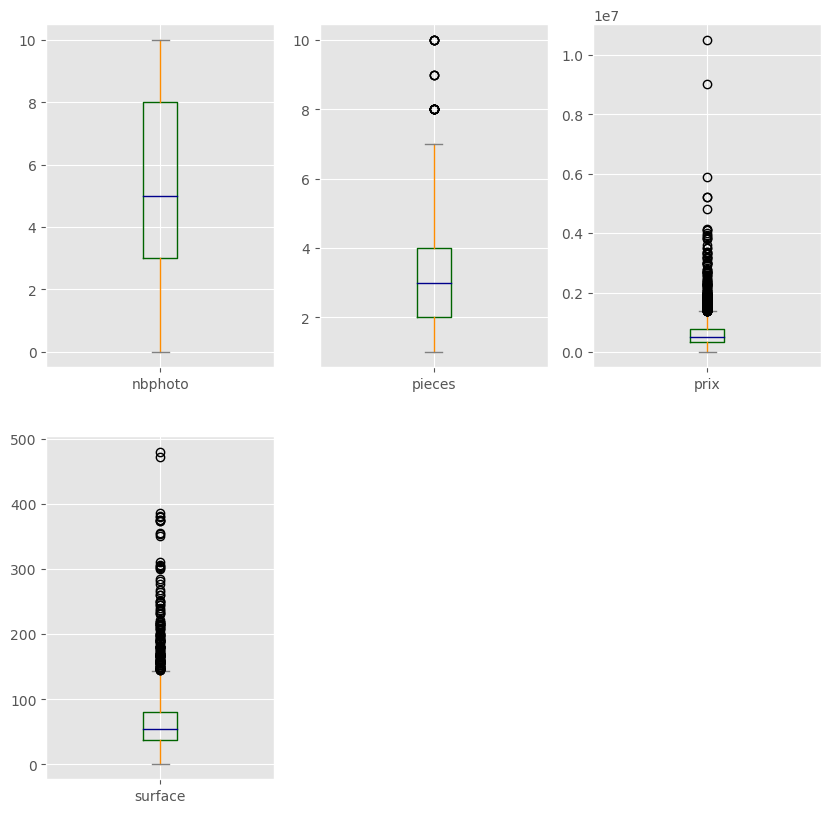

In [444]:
%matplotlib inline
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')

df.plot(kind = 'box', color=color, subplots=True, layout=(2,3), figsize = (10,10))

Surface and prix variables seem to have the same distribution. Indeed, they are both skewed right. This may be an hint of hight correlation between these two variables. We can also underline the fact that these two variables have a high number of outliers. Since the price is our target variable, it is a bad new. When predicting, we prefer to have variables with low number of outliers. Having too many outlier obervations is a problem for instance if we use linear regression. Indeed, outliers can yield leverage effect, which can bias the regression.

The distribution of pieces seems also skewed right whereas the distribution of nbphoto is symetric.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12e49fe80>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1333d5e80>]], dtype=object)

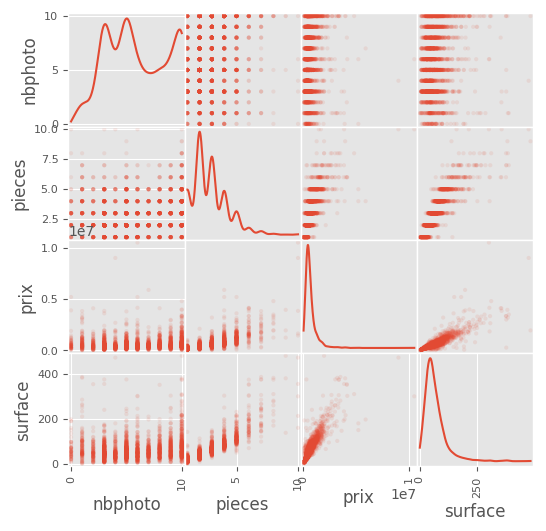

In [445]:
scatter_matrix(df, alpha=0.1, figsize=(4, 4), diagonal='kde')

This estimates the density of the numerical variables (using nonparametric kernel density method) on the diagonal, and plot the observations using each possible pair of variables as axis. As we said previously, pieces, prix and surface are all skewed right. Here, we can see that nbphoto is not so symetric.

By looking at the plots, we can clearly see linear relations between prix and surface and prix and pieces. Therefore, we expect surface and pieces to be important predictors of housing price. The number of photo does not seem to be linked to the price.

From now, since some numerical variables are linearly related to the price, we can expect a simple linear regression to be not so bad.

### b) Categorical predictors

For categorical predictors, we will look at their frequencies to see if some categories are not well represented, and we will try to see if the mean price vary significantly between categories of a same variable (to have an idea about the relation between categorical predictors and the price).

In [446]:
categorical_var = ['cp', 'ges', 'nrj', 'offres']

In [447]:
# To get the proportion of each category for the categorical variables
for i, column in enumerate(categorical_var):
    display((df[column].value_counts()/df.shape[0]).to_frame().round(2).transpose())

,75015,75018,75016,75011,75017,75019,75013,75020,75012,75010,75014,75007,75008,75005,75004,75006,75009,75003,75116,75002,75001
cp,0.12,0.09,0.09,0.08,0.08,0.07,0.07,0.06,0.06,0.05,0.05,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01


,Not defined,e,d,c,f,b,g,a
ges,0.43,0.16,0.11,0.09,0.09,0.08,0.03,0.02


,Not defined,d,e,f,c,g,b,a
nrj,0.39,0.21,0.2,0.06,0.06,0.03,0.03,0.01


,pro,part
offres,0.9,0.1


We can see that the 15th district is the most represented, and the 1st the less. Moreover, as we said before, we do not know the ges and nrj for almost 40% of the observations. Finally, the main part of the announces in Leboncoin come from professionals.

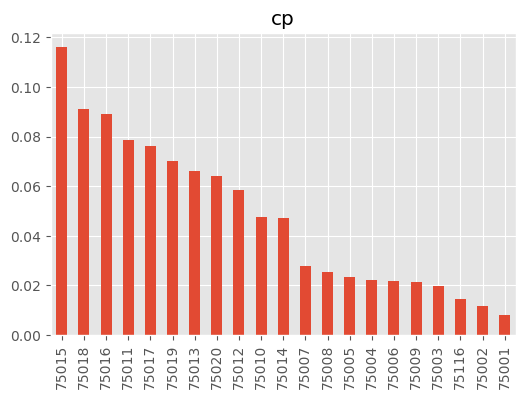

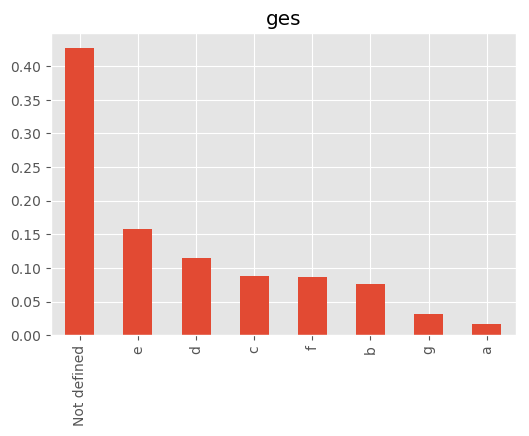

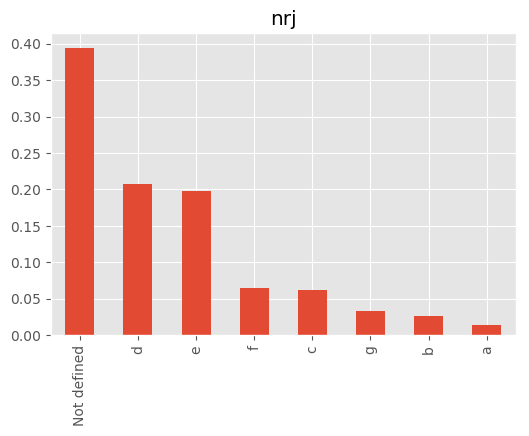

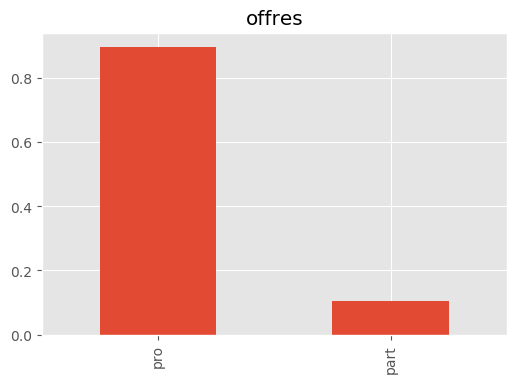

In [448]:
# Normalized histogram for categorical variables
for i, column in enumerate(categorical_var):
    (df[column].value_counts()/df.shape[0]).plot(kind = 'bar', subplots = True)
    plt.show()

Now, I look at the mean price for each categories of each categorical predictor.

cp,75001,75002,75003,75004,75005,75006,75007,75008,75009,75010,75011,75012,75013,75014,75015,75016,75017,75018,75019,75020,75116
prix,652686.863636,750664.375,702086.111111,885497.15,574523.460317,745789.830508,1.231585e+06,1.319348e+06,779713.603448,621514.953488,550931.361502,516501.27673,491694.949721,683266.742188,582475.660317,883971.157025,820626.149758,456644.817814,438633.602094,454644.54023,1184610.0


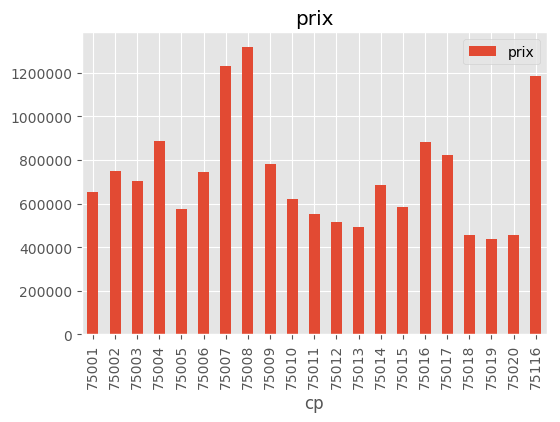

ges,Not defined,a,b,c,d,e,f,g
prix,641989.499139,567438.695652,625594.091346,593489.675,737465.559486,732163.375291,605096.693617,628744.823529


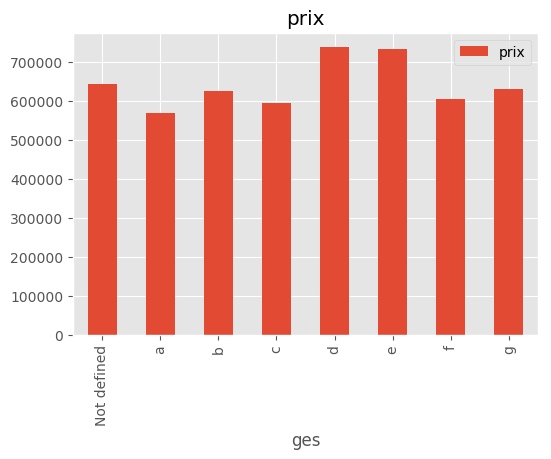

nrj,Not defined,a,b,c,d,e,f,g
prix,642997.304104,626150.769231,790306.291667,814963.392857,657371.897345,705711.970149,468398.514286,500793.370787


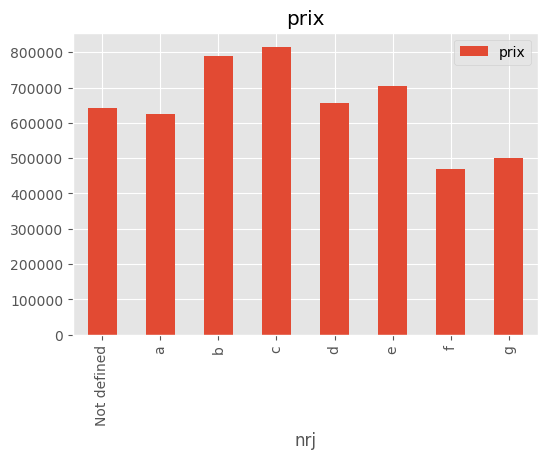

offres,part,pro
prix,604096.19573,662831.601643


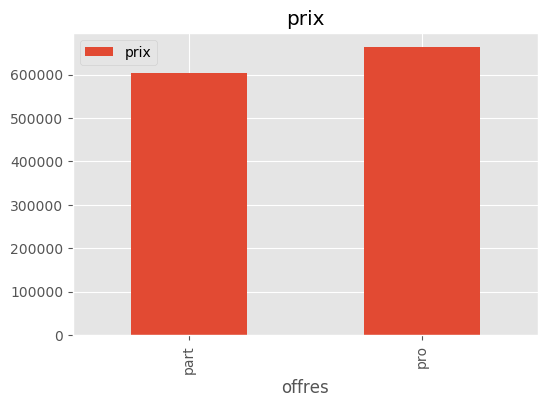

In [449]:
# Mean price for each category
for i, column in enumerate(categorical_var):
    display(df.groupby(column)['prix'].mean().to_frame().transpose())
    df.groupby(column)['prix'].mean().to_frame().plot(kind = 'bar', subplots = True)
    plt.show()

These descriptive statistics give us insights about the relation between categorical variables and the price. But differences of mean price between categories are not always significant since we only have few observations for some categories.

We can see that some districts are more expansive than other, the price does not seem to be impacted by ges, appartments with better nrj are more expensive and, appartments from professionals are more expensive (but this last remark may be not significant since only 10% of the announces come from individuals).

From these categorical variables, the one which seems to impact the more the price is the district. We can expect the district to be a strong predictor of the appartment price.

In [ ]:
# Here, I correct a small problem, indeed, in the data have the '75116' category for the district, which is in
# fact 75016
df['75016'] = df['75016'] + df['75116']
df = df.drop(['75116'], axis = 1)

## 4] Feature engineering

We just saw descriptive statistics about our baseline features. These should be already good predictors, but we are going to extract other usefull information from the announces' descriptions to get more accurate predictions.

### a) Binarize categorical variables

First, I transform categorical variables into dummy variables.

In [450]:
# Here, we drop a first category to avoid multicolinearity and be able to implement regressions directly
appended_data = [df]
for i, cate_column in enumerate(categorical_var):
    appended_data.append(pd.get_dummies(df[cate_column], drop_first=True))

data = pd.concat(appended_data, axis=1)

# Delete non binarized categorical variables
data = data.drop(categorical_var, axis = 1)

### b) Creating 2 new features

I decided to create 2 features which are the number of rooms squared, and an interaction term between the number of rooms and the surface. Indeed, these terms are often used in the economic litterature. Indeed, when using linear regression, the interaction term allows the impact of an increase in the number of rooms on the price to vary with the surface area, which makes sense.

In [451]:
data['pieces_sqrt'] = data['pieces'] **2
data['pieces_surface'] = data['pieces'] * data['surface']

### c) Generating features from announces' descriptions

A first step in text mining consists on deleting stopwords, punctuation and numbers from the text. Then we can put it to lower and stemming the words to only keep words' roots. In python, there exist only one module for stemming french documents. It is not perfect, but I will use it.

#### Text cleaning

In [452]:
# Delete accent
data['description'] = data['description'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

# Put to lower
data['description'] = data['description'].str.lower()

# Remove digits
remove_digits = str.maketrans('', '', digits)

for i in range(len(data)):
    data.loc[i, 'description'] = data.description[i].translate(remove_digits)

# Remove punctuation
def remove_punctuation(s):
    s = ''.join([i for i in s if i not in frozenset(string.punctuation)])
    return s

data['description'] = data['description'].apply(remove_punctuation)

# Remove stop words
from nltk.corpus import stopwords
stop = set(stopwords.words('french'))
stop = set(pd.Series(np.array(list(stop))).str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))

for i in range(len(data)):
    data.loc[i, 'description'] = ' '.join([j for j in data.description[i].split(' ') if j not in stop])

## Stemming words (it is not perfect but it is the only frenc stemmer implemented in python)
stemmer = FrenchStemmer()

for i in range(len(data)):
    data.loc[i, 'description'] = ' '.join([stemmer.stem(j) for j in data.description[i].split(' ')])

#### Document-term matrix

Now that the descriptions are cleaned, we create a document-term matrix.

In [453]:
### Create document term matrix
count = CountVectorizer(stop_words=stop, max_df=0.99, min_df=0.01)
dtm = pd.DataFrame(count.fit_transform(data.description).toarray(), columns=count.get_feature_names())

In [ ]:
# I save the liste for the datavizualization part latter
list_pca_learning = list(dtm.columns)
filename = '/Users/Linger/Desktop/list_pca_learning.sav'
pickle.dump(list_pca_learning, open(filename, 'wb'))

Since this is a very sparse matrix, we can expect to decrease its size without loosing too much information. To do so, we will use a PCA.

#### Number of final dimensions

First of all, we need to choose the number of final components. To do so, I will plot the eigenvalues from the covariance matrix decomposition. The plot displays an elbow, and we choose the number of final components corresponding to that elbow. By doing so, we try to find a good trade-off between matrix' size reduction and information loss.

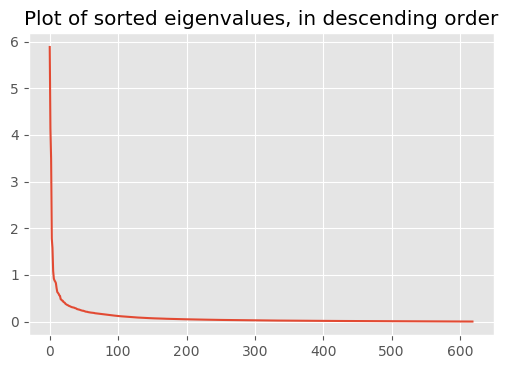

In [16]:
cov_mat = np.cov(dtm.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
sorted_eigen = []
for i in eig_pairs:
    sorted_eigen.append(i[0])

plt.plot([i for i in range(len(sorted_eigen))], sorted_eigen)
plt.title('Plot of sorted eigenvalues, in descending order')

As I said before, this sparse matrix can be summarize using a low number of axis, here let's say 40.

#### PCA

Here I save the PCA model which we will use in the wab application.

In [17]:
X = dtm.as_matrix()
pca = PCA(n_components=40)
reduced_X = pca.fit_transform(X)
pca_ = pca.fit(X)
dtm_reduced = pd.DataFrame(reduced_X)

In [18]:
# save the PCA model
filename = '/Users/Linger/Desktop/pca_transfo.sav'
pickle.dump(pca_, open(filename, 'wb'))

Then, we save the data which we are going to use for building models.

In [460]:
# Here I concatenate the 2 dataframes
final_data = pd.concat([data, dtm], axis=1)
final_data = final_data.drop(['announce', 'description', 'titre'], axis = 1)

In [461]:
final_data.to_csv('/Users/Linger/Desktop/ENSAE_MS/S1/Python/Projet/modelization_data_pca')

## 5] Modelization

In [3]:
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [5]:
data = pd.read_csv('modelization_data_pca', index_col=0)
data = data.drop_duplicates()
data.index = range(len(data))

In [20]:
print(data.shape)
data.head()

(2696, 80)


,nbphoto,pieces,prix,surface,75002,75003,75004,75005,75006,75007,75008,75009,75010,75011,75012,75013,75014,75015,75016,75017,75018,75019,75020,a,b,c,d,e,f,g,a.1,b.1,c.1,d.1,e.1,f.1,g.1,pro,pieces_sqrt,pieces_surface,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,10.0,2.0,430000.0,42.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,4.0,84.0,-1.206696,2.026088,-0.826469,1.546878,1.537913,0.179918,2.516330,-1.147526,0.302093,1.220190,-0.321770,1.914684,-0.976409,0.509320,-1.813669,0.835041,-2.050953,1.321733,-0.157766,1.481748,0.132081,0.188884,-0.383015,0.970516,0.527954,0.643704,0.011097,0.914708,0.884376,0.776373,-0.578886,-0.034801,-0.434265,0.339380,1.248892,-0.727862,-0.783205,0.381076,0.999178,0.931001
1,8.0,5.0,1490000.0,167.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,25.0,835.0,-2.625876,1.133736,-0.060397,1.164285,0.715911,-1.091812,-0.052962,0.873341,-1.540885,0.719150,-0.337193,2.135445,0.388462,0.024551,-0.421547,-0.507753,0.549135,0.489605,-0.028017,-0.319195,-0.413780,-0.477152,0.459288,0.220502,0.021717,-0.007444,0.822755,1.397772,-0.710164,-0.057018,0.540915,0.306504,0.177490,-0.421052,0.287690,-0.242639,-0.357194,-0.493233,0.751270,-0.190977
2,7.0,3.0,845000.0,83.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,9.0,249.0,-2.913505,0.173074,0.073715,0.941293,0.988589,-0.735023,-1.034584,1.107961,-0.841626,1.733173,0.622431,0.608981,0.702147,-0.141250,-1.029627,-1.195366,0.587890,-0.213890,0.273489,-0.557084,-1.120728,0.145734,0.025220,-0.193531,-0.527031,0.267264,0.104580,0.257214,-0.403439,1.087424,0.169355,-0.137177,-0.038422,-0.370274,0.270602,0.356910,0.079663,-0.359677,-0.306441,-0.436941
3,7.0,2.0,325000.0,33.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,4.0,66.0,-0.702679,3.640943,-2.347547,-0.800138,-0.708150,-0.066017,-0.720209,0.245847,-0.100615,-0.612746,-0.583325,-0.400325,0.504201,-0.785166,-0.540576,0.885188,-0.417208,-1.075434,-0.561624,0.665058,0.588760,0.866240,-0.494674,-0.005798,0.466468,0.151514,1.127762,-0.088220,-0.452951,0.589399,0.152023,-0.199690,0.748575,0.158758,0.282281,-0.259900,0.280214,0.232537,0.331952,-0.367338
4,3.0,2.0,490000.0,45.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.0,90.0,-3.487505,0.122660,0.598836,-0.199170,-0.956685,0.210563,-0.355386,-0.858481,-0.713786,0.786532,-0.976969,0.324158,-0.573273,0.103652,0.014306,-0.638712,0.094126,-0.186725,-0.074469,0.696799,-0.635921,-0.167465,-0.461785,-0.156594,-0.138608,0.079931,-0.199945,0.468323,1.481545,-0.307850,0.076659,0.053384,-0.573839,0.169219,-0.347437,-0.231015,0.055732,0.369383,-0.372039,-0.480065


The data is made of 2,696 observations, 79 features and 1 target.

### Error score

The error score with which I will assess the models qualities is the following one:

$Error = \frac{1}{N}\sum\limits_{i=1}^{N}|prediction_i - price_i|$

where N is the total number of observations.

### Cross validation

Let us split the data into a train and a test set.

In [6]:
X = data.loc[:, data.columns != 'prix'].as_matrix()
Y = data.loc[:, 'prix'].as_matrix()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15)

### a) Benchmark

As I said in the introduction, I want my predicting model to be at least better than a simple multiplication between appartments' area and square meter price by district. I compute the error made by a such prediction rule, to have an error benchmark below which I must not fall.

In [9]:
# Square meter price for each district
arr = {'75002':11025, '75003':9585, '75004':11267,'75005':12031, '75006':13256, '75007':12361, '75008':10904,
       '75009':9892, '75010':8709, '75011':8202, '75012':7867, '75013':8988, '75014':9538, '75015':9028, '75016':9876,
       '75017':8738, '75018':7387, '75019':5743, '75020':7336}

In [10]:
def benchmark(data,X_test):
    X_test_df = pd.DataFrame(X_test)
    X_test_df.columns = [i for i in data.columns if i != 'prix']
    X_test_df.index = range(len(X_test_df))
    for i in arr.keys():
        if i != '75001':
            pos = np.where(X_test_df[i]==1)
            for j in pos[0]:
                X_test_df.loc[j, 'pred'] = X_test_df.loc[j, 'surface'] * arr[i]
        else:
            first_arr = np.where(X_test_df[list(arr.keys())].sum(axis=1)==0)
            for k in first_arr[0]:
                X_test_df.loc[k, 'pred'] = X_test_df.loc[k, 'surface'] * arr[i]
    return X_test_df

In [11]:
# Error with this simple prediction
pred = benchmark(data,X_test).pred
np.nanmean(abs(np.array(pred) - Y_test))

79458.20821114369

With this simple prediction rule, I do 79,458 euros in average error.

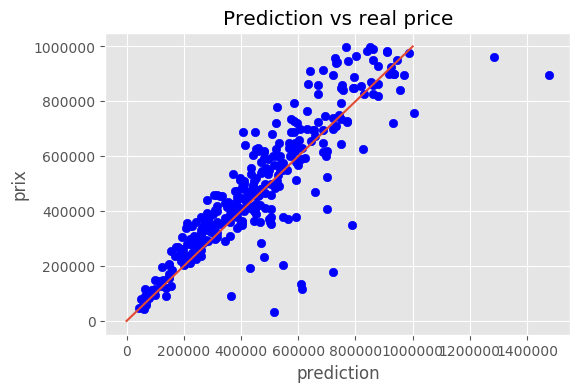

In [12]:
plt.scatter(pred,Y_test,c='blue')
plt.plot([0,1000000],[0,1000000])
plt.title('Prediction vs real price')
plt.ylabel('prix')
plt.xlabel('prediction')

### b) Linear model

The first prediction technique I want to try is a simple linear regression. Indeed, as we know that the surface area is linearly strongly correlated to the price, I expect to not predict too bad using a linear regression.

In [14]:
lm = LinearRegression()
lm.fit(X_train, Y_train)
prediction = lm.predict(X_test)

# Replace negative predictions by 0
prediction = prediction.clip(0)

In [15]:
# Error
np.mean(abs(prediction - Y_test))

73869.204132572966

Here, I am 5,589 more precise in my prediction than my benchmark is.

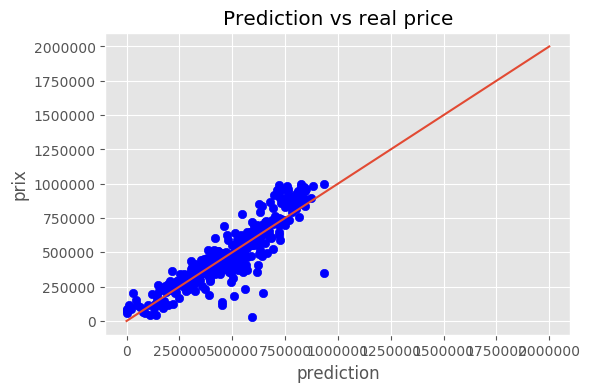

In [16]:
plt.scatter(prediction,Y_test,c='blue')
plt.plot([0,2000000],[0,2000000])
plt.title('Prediction vs real price')
plt.ylabel('prix')
plt.xlabel('prediction')

In general, my predictions are good, except for some observations. These predictions are still below my benchmark.

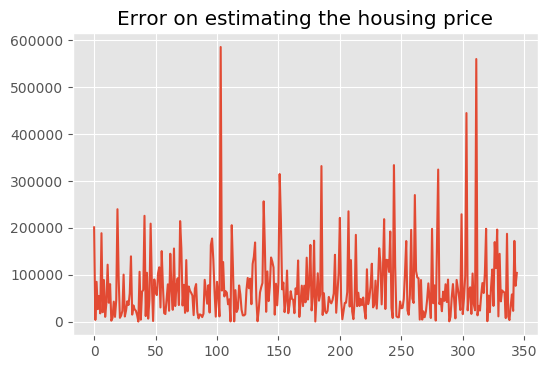

In [17]:
plt.plot([i for i in range(len(Y_test))], abs(prediction - Y_test))
plt.title('Error on estimating the housing price')

In general, I do not do a lot of errors, but for some houses, I do a lot. That is why I got high average error.

### c) Non linear model

In [13]:
lm = GradientBoostingRegressor(loss = 'ls')
lm.fit(X_train, Y_train)
prediction = lm.predict(X_test)

np.mean(abs(prediction - Y_test))

71584.50172083935


This model is slightly better than the linear model we used previously. This can come from the fact that it is a non linear model, and we can expect non linear relations between our predictors and the price since we have a lot of categorical and textual features. Moreover, GBRT is known to be robust to outliers, and we saw with the descriptive statistics that our data contain a lot of outliers regarding the price.

### d) Create feature interactions and use Lasso

An intuition I have is that I did not extract enought information from the description announces. Indeed, from now, the textual variables I used come from a dimension reduction of a simple document term matrix. By using it, I do not take into account interaction between words. Therefore, I decided to create interation between each variables and then use a Lasso regression to put weight on only a subset of the predictors.

In [7]:
poly = PolynomialFeatures(interaction_only=True)
X_train_multi = poly.fit_transform(X_train)
X_test_multi = poly.fit_transform(X_test)

I did not find any heuristic to set the regularization term. Therefore, I used GridSearch to approach the best one using cross validation on my training set.

In [ ]:
parameters = {'alpha': [100, 1000, 2000, 3000]}
lasso = Lasso()
clf = GridSearchCV(lasso, parameters)
clf.fit(X_train_multi, Y_train)

In [11]:
clf.best_estimator_

Lasso(alpha=3000, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
lasso = Lasso(alpha=3000)
lasso.fit(X_train_multi, Y_train)
prediction = lasso.predict(X_test_multi)

# Replace negative predictions by 0
prediction = prediction.clip(0)

In [14]:
# Number of coefficients used to build the model
len(np.where(lasso.coef_!=0)[0])

205


I use only 205 predictors out of $\frac{79.78}{2} + 79 + 1 = 3161$ predictors.

In [23]:
# Error
np.mean(abs(prediction - Y_test))

64726.534507615033

This is the best prediction method I used and I will use to predict housing price in Paris. Indeed, it does 6,857 euros less errors in average than the previous model. Compared to my benchmark, using this model is 14,732 euros more precise.

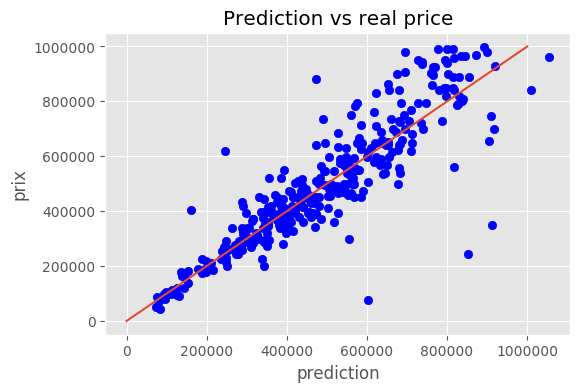

In [28]:
plt.scatter(prediction,Y_test,c='blue')
plt.plot([0,1000000],[0,1000000])
plt.title('Prediction vs real price')
plt.ylabel('prix')
plt.xlabel('prediction')

In [ ]:
# save the model to use in the Dash app
filename = '/Users/Linger/Desktop/finalized_model.sav'
pickle.dump(lasso, open(filename, 'wb'))

## 6] Visualization

I create a web application using the Dash module. This module is quiete new and do not recquire the user to know html. In the app, I ask the user to fill some information and I output the predicted price of the corresponding appartment.

Therefore, I need to call some models. The app treats the input information as follows:

- It creates a vector of binary variables with district, GES, NRJ, professional, number of pictures, number of rooms and surface area.

- It creates an occurency terms vector aligned on the words met in the training set.

- It creates a lower representation of the terms occurency vector using the PCA model.

- It concatenates the 2 features vectors and creates interactions between each pair of features.

- Then, the Lasso regression model is called to predict the housing price.

In the Dash app, I limit the range choice of some variables. For instance, the surface area the user can choose is limited to 250 square meters. I did it because in my training set, only few observations have a surface area greater than 250 square meters and so my predictions for these observations will not be robust.

In [ ]:
# To run the Web app, be sure to be able to import the following modules
import dash
from dash.dependencies import Input, Output, State, Event
import dash_core_components as dcc
import dash_html_components as html

import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
import base64

# For the PCA
import unidecode
from string import digits
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
from sklearn.decomposition import PCA

In [ ]:
# To start the app, go on your terminal and enter
python app2.py

## 7] Conclusion

With this project, I learned a lot since I did not know anything about web scraping and dataviz with python. Therefore, I spent a lot of time on the data cleaning and data visualiation parts, and a little bit less on the modelization.

We can think about many applications for this model and web app. For instance, it could be used by Leboncoin to suggest a price to users when they enter a new announce. Also, it could be used by buyers to compare the current price of an announce to the one predicted by the model, to see if an announce's price is a bargain or not. In a more personal way, if I trust in my datascientist skills, I could use it to buy cheap appartments and resell them at the price predicted by my model, to make money!

I see some good points in my work:

- Firstly, it beats my simple benchmark model by 14,732 euros in average. Therefore, we prooved that we bring usefull information by considering announces' descriptions and other features.

- Secondly, since each day new announces come on leboncoin, we could think about a bayesian approach which could incorporate new information to the model as new announces come. Therefore, if the model was used by Leboncoin, we could expect its performances to be improved as the flow of new announces comes.

- Thirdly, I think that the web app is easy to use (as my mother succeded!).

- Moreover, the training and prediction part are very fast. Nevertheless, this time will increase as we have more announces because with more observations, the size of the document term matrix to consider will increase.

- From the data scraping to the data visualization, everything is automatic, i.e that only running this code can create a new model and use it in the Dash app. We do not need to monitor too much this project (except if a new error raises). The main point that need to be monitored is the choice of the regularization for Lasso. I set it using GridSearchcv but as new observations come, the set of proposed regularizations might need to be adapted.

Nevertheless, I am conscious that my work has some limitations:

- First of all, since the information recquired to create a new announce on Leboncoin are not all mandatory, I could not use many interesting variables because they displayed too many NaN. In the same maner, the price displayed in Leboncoin include or not honoraries, which increase the variance of my target variable (the price) and make difficult its prediction.

- Secondly, when using the Dash app, you will see that relations between predicted price and some variables do not always make sense. For instance, for an NRJ 'a', the price of the appartment is predicted to be lower than for one with an NRJ 'b', which is contreintuitive. This can come from the fact that in my training set, these 2 classes are not well represented (less than 5%). Therefore, the prediction for observations in these categories is less robust than for others. This problem could have been erased if I had collected more announces (and more heterogeneous announces).

- Thirdly, we can see from the plots 'prices vs predictions' of the part '5] Modelization' that my model struggles more to predict expensive houses. Again, as my target variable is skewed right, expensive houses are not well represented, which can explain the higher errors for these appartments. This can be anticipated since the surface area is highly correlated to the price. Indeed, we can expect the prediction's errors to be higher as the surface area of the considered appartment increases.

- Moreover something that can be interpreted as a drawback of my model is that it is a Blackbox. Indeed, since I mainly use latent variables and interactions between these latent variables to build the model, it does not have any economic interpretation. In my opinion it is not a drawback as we are here only interested in prediction's accuracy.

- Finally, we can expect the accuracy of the model to decrease with the time, if it is not often updated (i.e. if we do not learn the model with new annouces). Indeed, many economic factors can cause an increase or decrease in housing price in Paris such as inflation... Therefore, it is really important that the model regularly take into account new announces.

## 8] Video

### a) Dataviz for video presentation

The aim of this part is to vizualize the data constituting my training sample in order to guess the weaknesses of my model.

In [2]:
data = pd.read_csv('modelization_data_pca', index_col=0)
data = data.drop_duplicates()
data.index = range(len(data))

In [3]:
data['75001'] = data.iloc[:,4:4+19].sum(axis=1)
data = data.replace({'75001': {1: 2}})
data = data.replace({'75001': {0: 1}})
data = data.replace({'75001': {2: 0}})

In [4]:
x = data.loc[:,['7500{}'.format(i+1) for i in range(9)] + ['750{}'.format(i+1) for i in range(9, 20)]].stack()

In [5]:
data['arrondissement'] = pd.Series(pd.Categorical(x[x!=0].index.get_level_values(1)))

In [41]:
markers = pd.DataFrame({'arrondissement':['1er','2nd']+['{}ème'.format(i) for i in range(3,21)], 'lat':[48.8640493,48.8675641,48.8634799,48.8534275,48.8434912,
                        48.8488576,48.85433450000001,48.8718722,48.8790183,48.8785618,48.85799300000001,48.8293647,48.830759,
                        48.8314408,48.8421616,48.8585799,48.891986,48.891305,48.88237609999999,48.8599825],
                        'lon':[2.331052600000021,2.3439899999999625,2.3591145000000324,2.3582787999999937,2.351833899999974,
                        2.3354223000000047,2.3134029000000282,2.3176432000000204,2.337906299999986,2.360368900000026,2.3811530000000403,2.426540599999953,2.359203999999977,
                        2.3255684000000656,2.2927664999999706,2.284701700000028,2.319287000000031,2.352986699999974,2.382291699999996,2.4066411999999673]})

In [8]:
test_mean_price = data.groupby('arrondissement')['prix'].mean().to_frame().reset_index()

In [21]:
for i in range(len(markers)):
    markers.arrondissement[i] = markers.arrondissement[i] + ' : ' + str(int(test_mean_price.prix[i])) + '€'

/Users/Linger/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [24]:
import folium
from branca.colormap import linear

colormap = linear.YlGn.scale(
    test_mean_price.prix.min(),
    test_mean_price.prix.max())

import json

state_geo = os.path.join('/Users/Linger/Desktop/Projet_Python/', 'arrondissements_osm_paris.geojson')

geo_json_data = json.load(open(state_geo))

prix_dict = test_mean_price.set_index('arrondissement')['prix']

m = folium.Map(location=[48.866667, 2.333333], zoom_start=12)

feature_group = folium.FeatureGroup("Locations")

for lat, lng, name in zip(markers.lat, markers.lon, markers.arrondissement):
    feature_group.add_child(folium.Marker(location=[lat,lng],popup=name))

m.add_child(feature_group)

folium.GeoJson(
    geo_json_data,
    name='unemployment',
    style_function=lambda feature: {
        'fillColor': colormap(prix_dict[feature['id']]),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.7,
    }
).add_to(m)

folium.LayerControl().add_to(m)

colormap.caption = 'Mean price'
colormap.add_to(m)

In [25]:
m

In [33]:
# Number of observations

test_count = data.groupby('arrondissement')['prix'].count().to_frame().reset_index()
test_count.columns = ['arrondissement', 'count']


for i in range(len(markers)):
    markers.arrondissement[i] = markers.arrondissement[i] + ' : ' + str(int(test_count['count'][i])) + ' observations'


colormap = linear.RdPu.scale(
    test_count['count'].min(),
    test_count['count'].max())


count_dict = test_count.set_index('arrondissement')['count']

m = folium.Map(location=[48.866667, 2.333333], zoom_start=12)

feature_group = folium.FeatureGroup("Locations")

for lat, lng, name in zip(markers.lat, markers.lon, markers.arrondissement):
    feature_group.add_child(folium.Marker(location=[lat,lng],popup=name))

m.add_child(feature_group)

folium.GeoJson(
    geo_json_data,
    name='unemployment',
    style_function=lambda feature: {
        'fillColor': colormap(count_dict[feature['id']]),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.7,
    }
).add_to(m)

folium.LayerControl().add_to(m)

colormap.caption = 'Number of observations'
colormap.add_to(m)

/Users/Linger/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [34]:
m

In [35]:
m.save('nb_obs.html')

Mon échantillon est composé en partie d'appartements dans les arrondissements aux extrêmités de Paris. De ce fait, mon model de prédiction devrait être moins précis lorsque j'estimerai le prix des appartements dans le 1er arrondissement par exemple. Toutefois, j'ai décidé de faire un modèle afin de prédire le prix des appartements pour chacun des arrondissements.

In [42]:
# Square meter price

test = data.loc[:,['arrondissement', 'prix', 'surface']]
test['prix_per_sq'] = test.prix/test.surface
test_prix_per_sq = test.groupby('arrondissement')['prix_per_sq'].mean().to_frame().reset_index()

for i in range(len(markers)):
    markers.arrondissement[i] = markers.arrondissement[i] + ' : ' + str(int(test_prix_per_sq.prix_per_sq[i])) + '€/m2'

colormap = linear.PuBu.scale(
    test_prix_per_sq.prix_per_sq.min(),
    test_prix_per_sq.prix_per_sq.max())


prix_sq_dict = test_prix_per_sq.set_index('arrondissement')['prix_per_sq']

m = folium.Map(location=[48.866667, 2.333333], zoom_start=12)

feature_group = folium.FeatureGroup("Locations")

for lat, lng, name in zip(markers.lat, markers.lon, markers.arrondissement):
    feature_group.add_child(folium.Marker(location=[lat,lng],popup=name))

m.add_child(feature_group)

folium.GeoJson(
    geo_json_data,
    name='unemployment',
    style_function=lambda feature: {
        'fillColor': colormap(prix_sq_dict[feature['id']]),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.7,
    }
).add_to(m)

folium.LayerControl().add_to(m)

colormap.caption = 'Square meter price'
colormap.add_to(m)

/Users/Linger/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [43]:
m

In [44]:
m.save('price_sqm.html')